# 学習と評価
 - 二値分類モデルの並列を行い，マルチラベル問題を解く
 - FaceNetの利用

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from pathlib import Path

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.8.0'

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
from sklearn.model_selection import KFold

## データのロード

- 画像サイズは224×224

In [7]:
df = pd.read_csv("data1_union.csv")

In [8]:
df

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,6269,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,272998,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,274783,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3,430823,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,208848,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
80,185955,0.0,1.0,1.0,1.0,1.0,0.0,0.0
81,313100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
82,369866,1.0,1.0,0.0,1.0,1.0,0.0,0.0
83,124821,0.0,1.0,1.0,1.0,0.0,0.0,1.0


## FaceNetで埋め込み

メモ：```\Lib\site-packages\facenet\src\facenet.py```の408行目をtensorflow v2仕様に書き換える必要がある

In [9]:
from face_embedding import FaceEmbedding

In [10]:
FACE_MEDEL_PATH = '../facenet//20180402-114759/20180402-114759.pb'
face_embedding = FaceEmbedding(FACE_MEDEL_PATH)

Model filename: ../facenet//20180402-114759/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.


In [11]:
X = []
for img_id in df["Id"]:
    path = f"images/cleaned_20220519/{img_id}.jpg"
    face_vec = face_embedding.face_embeddings(path)[0]
    X.append(face_vec)

In [12]:
X = np.array(X)

In [13]:
X.shape

(85, 512)

## モデル構築

In [14]:
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Lambda, Conv2D, Reshape, Input, RandomFlip, RandomRotation

In [15]:
def get_binary_model(fine=False):
    input_ts = Input(shape=(512,))
    dense1 = Dense(512, activation="relu")(input_ts)
    dense2 = Dense(1024, activation="relu")(dense1)
    drop1 = Dropout(0.4)(dense2)
    dense3 = Dense(1024, activation="relu")(drop1)
    drop2 = Dropout(0.4)(dense3)
    dense4 = Dense(512, activation="relu")(drop2)
    dense5 = Dense(256, activation="relu")(dense4)
    dense6 = Dense(128, activation="relu")(dense5)
    drop3 = Dropout(0.2)(dense6)
    final = Dense(2, activation="softmax")(drop3)
    
    model = Model(
        inputs=[input_ts],
        outputs=[final]
    )
    return model

### まずは一つのラベルでテストする

In [24]:
# まずはconfidentでやってみる
y_raw = df["Confident"]
y = tf.keras.utils.to_categorical(y_raw)

In [25]:
model = get_binary_model()

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               5248

In [27]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [28]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=METRICS)

In [29]:
kf = KFold(n_splits=3, shuffle=True, random_state=1001)

In [30]:
from sklearn.metrics import f1_score

In [31]:
accs = []
f1s = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_test_sk = np.argmax(y_test, axis=1)
    
    neg = y_train.sum(axis=0)[0]
    pos = y_train.sum(axis=0)[1]
    total = pos + neg
    print(f"origin pos:{pos} neg:{neg}")
    
    
    # 初期重みの最適化
    initial_bias = np.log([neg/pos])
    model.layers[-1].bias_initializer=initial_bias
    
    # クラスの重み
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print(class_weight)
    
    
    model.fit(X_train, y_train, batch_size=1, epochs=5, class_weight=class_weight)
    y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)
    print("Predict:", y_pred)
    print("True:", y_test_sk)
    f1 = f1_score(y_test_sk, y_pred, average="binary")
    print("F1 score:", f1)
    f1s.append(f1)
    accs.append(model.evaluate(X_test, y_test, batch_size=1))

origin pos:43.0 neg:13.0
{0: 2.153846153846154, 1: 0.6511627906976745}
Epoch 1/5
56/56 [==============================] - 2s 11ms/step - loss: 0.6976 - tp: 37.0000 - fp: 19.0000 - tn: 37.0000 - fn: 19.0000 - accuracy: 0.6607 - precision: 0.6607 - recall: 0.6607 - auc: 0.7310      
Epoch 2/5
56/56 [==============================] - 0s 6ms/step - loss: 0.7926 - tp: 43.0000 - fp: 13.0000 - tn: 43.0000 - fn: 13.0000 - accuracy: 0.7679 - precision: 0.7679 - recall: 0.7679 - auc: 0.8017
Epoch 3/5
56/56 [==============================] - 0s 6ms/step - loss: 0.5897 - tp: 51.0000 - fp: 5.0000 - tn: 51.0000 - fn: 5.0000 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9196
Epoch 4/5
56/56 [==============================] - 0s 6ms/step - loss: 0.2244 - tp: 52.0000 - fp: 4.0000 - tn: 52.0000 - fn: 4.0000 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9566 
Epoch 5/5
56/56 [==============================] - 0s 6ms/step - loss: 0.1621 - tp: 54.0000 - fp: 2.0000 - tn

In [32]:
del model

## すべてのラベルでやってみる

In [33]:
labels = ["Caring","Confident","Emotionally stable","Intelligent","Responsible","Sociable","Trustworthy"]

In [34]:
kf = KFold(n_splits=3, shuffle=True, random_state=1001)

In [38]:
f1_dict = dict()
for label in labels:
    y_raw = df[label]
    y = tf.keras.utils.to_categorical(y_raw)
    
    f1_dict[label] = []
    print(label)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        neg = y_train.sum(axis=0)[0]
        pos = y_train.sum(axis=0)[1]
        total = pos + neg
        print(f"origin pos:{pos} neg:{neg}")

        # クラスの重み
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        model = get_binary_model()
        
        # 初期重みの最適化
        initial_bias = np.log([neg/pos])
        model.layers[-1].bias_initializer=initial_bias
        
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=METRICS)
        model.fit(X_train, y_train, batch_size=8, epochs=6, class_weight=class_weight)
        y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)
        y_test_sk = np.argmax(y_test, axis=1)
        print("Predict:", y_pred)
        print("True:", y_test_sk)
        f1 = f1_score(y_test_sk, y_pred, average="binary")
        print("F1 score:", f1)
        f1_dict[label].append(f1)
    

Caring
origin pos:21.0 neg:35.0
Epoch 1/6
7/7 [==============================] - 1s 24ms/step - loss: 0.7006 - tp: 75.0000 - fp: 38.0000 - tn: 75.0000 - fn: 38.0000 - accuracy: 0.6637 - precision: 0.6637 - recall: 0.6637 - auc: 0.8162
Epoch 2/6
7/7 [==============================] - 0s 10ms/step - loss: 0.6930 - tp: 34.0000 - fp: 22.0000 - tn: 34.0000 - fn: 22.0000 - accuracy: 0.6071 - precision: 0.6071 - recall: 0.6071 - auc: 0.6130
Epoch 3/6
7/7 [==============================] - 0s 6ms/step - loss: 0.6566 - tp: 35.0000 - fp: 21.0000 - tn: 35.0000 - fn: 21.0000 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.7278
Epoch 4/6
7/7 [==============================] - 0s 6ms/step - loss: 0.5170 - tp: 45.0000 - fp: 11.0000 - tn: 45.0000 - fn: 11.0000 - accuracy: 0.8036 - precision: 0.8036 - recall: 0.8036 - auc: 0.8836
Epoch 5/6
7/7 [==============================] - 0s 6ms/step - loss: 0.3200 - tp: 46.0000 - fp: 10.0000 - tn: 46.0000 - fn: 10.0000 - accuracy: 0.8214 - preci

8/8 [==============================] - 0s 8ms/step - loss: 0.1022 - tp: 57.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Predict: [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
True: [1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1]
F1 score: 0.7826086956521738
Emotionally stable
origin pos:16.0 neg:40.0
Epoch 1/6
7/7 [==============================] - 1s 11ms/step - loss: 0.6967 - tp: 90.0000 - fp: 23.0000 - tn: 90.0000 - fn: 23.0000 - accuracy: 0.7965 - precision: 0.7965 - recall: 0.7965 - auc: 0.9070
Epoch 2/6
7/7 [==============================] - 0s 10ms/step - loss: 0.6974 - tp: 40.0000 - fp: 16.0000 - tn: 40.0000 - fn: 16.0000 - accuracy: 0.7143 - precision: 0.7143 - recall: 0.7143 - auc: 0.7146
Epoch 3/6
7/7 [==============================] - 0s 12ms/step - loss: 0.6667 - tp: 40.0000 - fp: 16.0000 - tn: 40.0000 - fn: 16.0000 - accuracy: 0.7143 - precision: 0.7143 - recall: 0.7143 - a

8/8 [==============================] - 0s 8ms/step - loss: 0.6508 - tp: 27.0000 - fp: 30.0000 - tn: 27.0000 - fn: 30.0000 - accuracy: 0.4737 - precision: 0.4737 - recall: 0.4737 - auc: 0.6014
Epoch 5/6
8/8 [==============================] - 0s 8ms/step - loss: 0.5079 - tp: 49.0000 - fp: 8.0000 - tn: 49.0000 - fn: 8.0000 - accuracy: 0.8596 - precision: 0.8596 - recall: 0.8596 - auc: 0.9412
Epoch 6/6
8/8 [==============================] - 0s 9ms/step - loss: 0.4928 - tp: 44.0000 - fp: 13.0000 - tn: 44.0000 - fn: 13.0000 - accuracy: 0.7719 - precision: 0.7719 - recall: 0.7719 - auc: 0.8406
Predict: [0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1]
True: [0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1]
F1 score: 0.4848484848484848
Responsible
origin pos:25.0 neg:31.0
Epoch 1/6
7/7 [==============================] - 1s 13ms/step - loss: 0.6922 - tp: 71.0000 - fp: 42.0000 - tn: 71.0000 - fn: 42.0000 - accuracy: 0.6283 - precision: 0.6283 - recall: 0.6283 - auc: 0.7302
Epoch 

8/8 [==============================] - 0s 8ms/step - loss: 0.6486 - tp: 43.0000 - fp: 14.0000 - tn: 43.0000 - fn: 14.0000 - accuracy: 0.7544 - precision: 0.7544 - recall: 0.7544 - auc: 0.8510
Epoch 4/6
8/8 [==============================] - 0s 8ms/step - loss: 0.5264 - tp: 47.0000 - fp: 10.0000 - tn: 47.0000 - fn: 10.0000 - accuracy: 0.8246 - precision: 0.8246 - recall: 0.8246 - auc: 0.8707
Epoch 5/6
8/8 [==============================] - 0s 8ms/step - loss: 0.3003 - tp: 48.0000 - fp: 9.0000 - tn: 48.0000 - fn: 9.0000 - accuracy: 0.8421 - precision: 0.8421 - recall: 0.8421 - auc: 0.9461
Epoch 6/6
8/8 [==============================] - 0s 9ms/step - loss: 0.2404 - tp: 50.0000 - fp: 7.0000 - tn: 50.0000 - fn: 7.0000 - accuracy: 0.8772 - precision: 0.8772 - recall: 0.8772 - auc: 0.9769
Predict: [1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0]
True: [0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0]
F1 score: 0.3333333333333333
Trustworthy
origin pos:10.0 neg:46.0
Epoch 1/6

In [39]:
f1_list = []
for label in labels:
    f1_list.append(np.mean(f1_dict[label]))

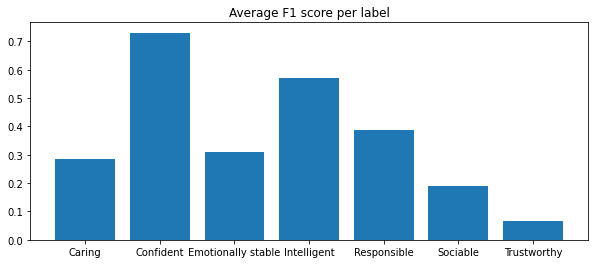

In [40]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), f1_list)
plt.title("Average F1 score per label")
plt.show() ;

### いろいろやってみてわかること
 - Predictを見るとわかるが，まったく学習できていない
 - 役に立たない　やはりデータが少なすぎるか

## おまけ？）LightGBM

In [44]:
X_train

array([[ 0.01686239, -0.02080622, -0.10246906, ...,  0.01567093,
         0.02755429, -0.00753543],
       [ 0.02704587, -0.034787  ,  0.03670312, ...,  0.02411952,
         0.00775679,  0.01972277],
       [ 0.03997304, -0.01156947,  0.05490813, ...,  0.01107565,
        -0.07515232,  0.02216491],
       ...,
       [ 0.00866971,  0.03657958, -0.02266627, ...,  0.08386027,
        -0.00338471, -0.03355016],
       [-0.01896611,  0.01163005, -0.01931574, ..., -0.07163159,
        -0.10350168, -0.0057108 ],
       [ 0.03666621, -0.03438604, -0.02219101, ..., -0.00174729,
        -0.04289525,  0.00565334]], dtype=float32)

In [42]:
import lightgbm as lgb

In [55]:
f1_dict = dict()
for label in labels:
    y_raw = df[label]
    y = tf.keras.utils.to_categorical(y_raw)
    
    f1_dict[label] = []
    print(label)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_test_sk = np.argmax(y_test, axis=1)
        y_train_sk = np.argmax(y_train, axis=1)
        
        neg = y_train.sum(axis=0)[0]
        pos = y_train.sum(axis=0)[1]
        total = pos + neg
        print(f"origin pos:{pos} neg:{neg}")

        # クラスの重み
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        model = lgb.LGBMClassifier(n_estimators=1000) 
        model.fit(X_train, y_train_sk) 
        y_pred = model.predict(X_test)

        print("Predict:", y_pred)
        print("True:", y_test_sk)
        f1 = f1_score(y_test_sk, y_pred, average="binary")
        print("F1 score:", f1)
        f1_dict[label].append(f1)
    

Caring
origin pos:21.0 neg:35.0
Predict: [0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0]
True: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
F1 score: 0.3
origin pos:17.0 neg:40.0
Predict: [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0]
True: [1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
F1 score: 0.0
origin pos:14.0 neg:43.0
Predict: [0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
True: [1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0]
F1 score: 0.25
Confident
origin pos:43.0 neg:13.0
Predict: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1]
True: [1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1]
F1 score: 0.8085106382978724
origin pos:42.0 neg:15.0
Predict: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1]
True: [0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
F1 score: 0.8571428571428572
origin pos:45.0 neg:12.0
Predict: [1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0]
Tr

In [56]:
f1_list = []
for label in labels:
    f1_list.append(np.mean(f1_dict[label]))

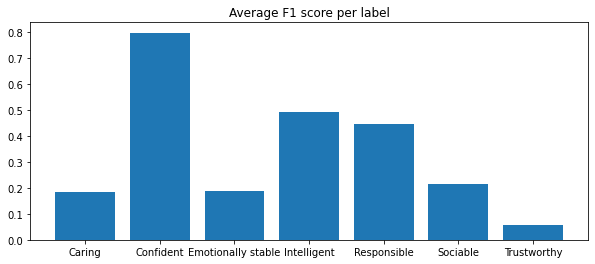

In [57]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), f1_list)
plt.title("Average F1 score per label")
plt.show() ;